Downloading...
From: https://drive.google.com/uc?id=15LSYaKYgg9GrVJgwSE_dBTPDefqShAaD
To: C:\Users\signo\dati.txt
100%|██████████| 771k/771k [00:00<00:00, 7.25MB/s]


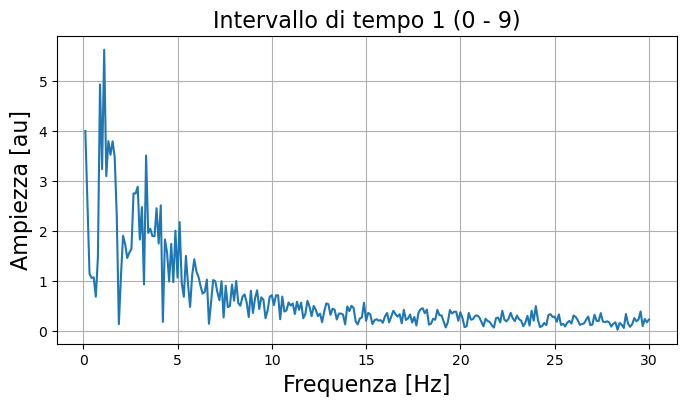

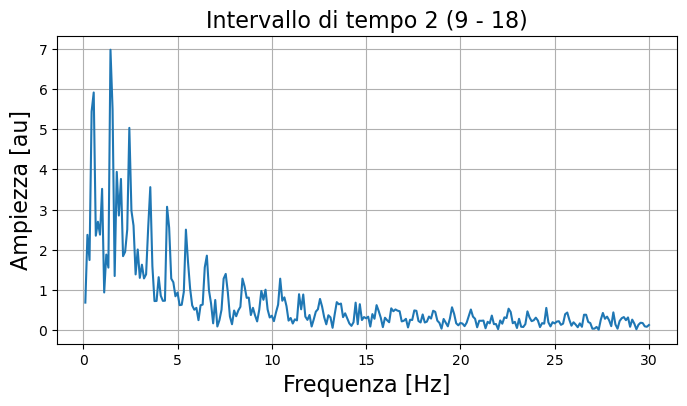

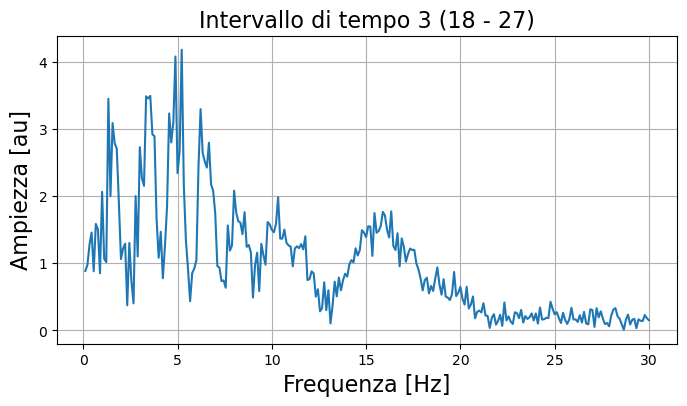

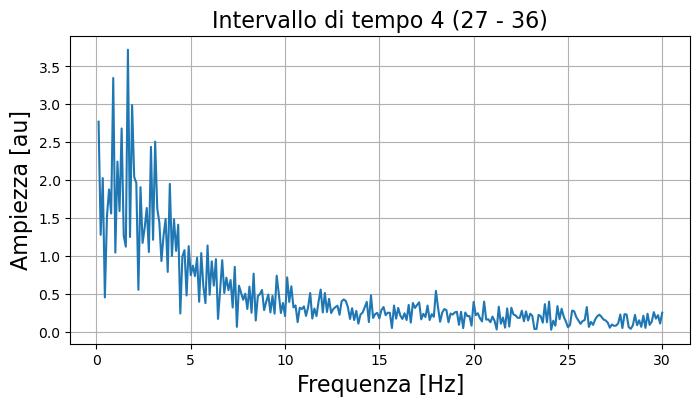

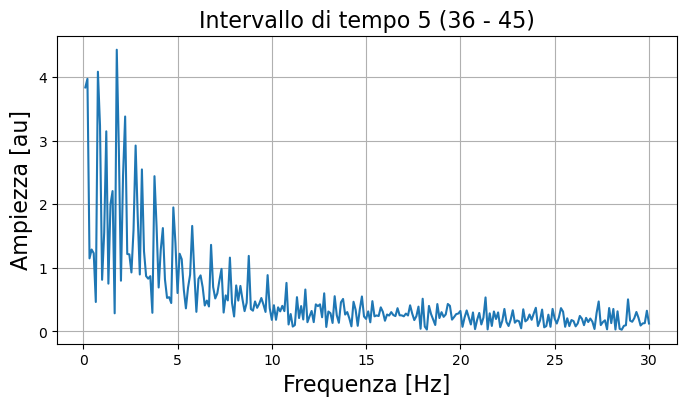

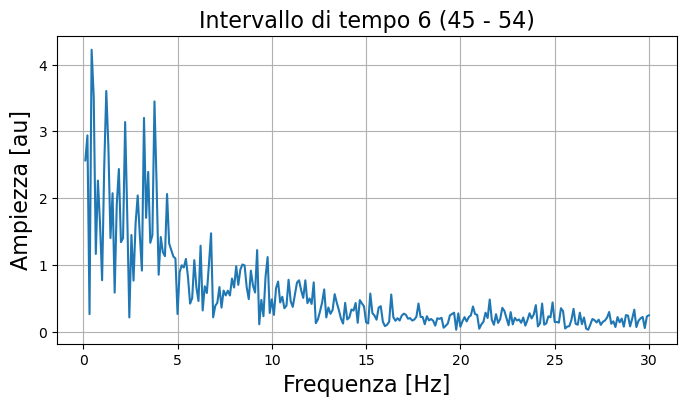

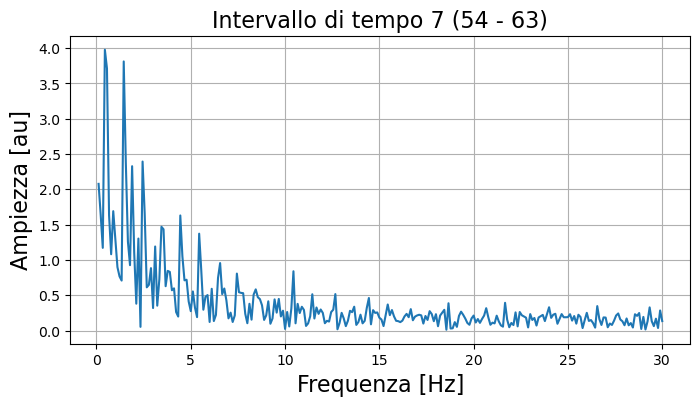

Massimi breath rate:  [1.4794022119372527, 5.911647564499196, 1.5061496023153098, 1.046408306075209, 1.1498564143897902, 2.9384190171387696, 3.712661110716268]
Media dei massimi valori di ampiezza tra 0 e 1 Hz: 2.534934889581685
brpm 76.04804668745055
Massimi heartbeat:  [2.304187569820425, 5.492102444371049, 4.0784158082828865, 2.043564922106633, 1.5936034534409806, 3.137935079002089, 3.811279011335296]
Media dei massimi valori di ampiezza tra 0.66 e 6.66 Hz: 3.208726898337051
bpm 96.26180695011153


In [3]:
#senza overlap
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from Lettura_Dati import leggi_file  # importo la funzione per leggere il file
import warnings
from background_piuframe import Background_PiuFrame
import gdown
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from matplotlib.backends.backend_pdf import PdfPages
import os

# ignoro gli avvisi durante l'esecuzione del codice -> quando faccio log10
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Link con l'ID del file
file_url = "https://drive.google.com/uc?id=15LSYaKYgg9GrVJgwSE_dBTPDefqShAaD"
# Scarica il file da Google Drive
gdown.download(file_url, 'dati.txt', quiet=False)

# Leggi il file
file_path = "dati.txt"
frames = leggi_file(file_path)
frames_array = np.array(frames)

# Parametri
Nm = 9  # n di frame per blocco
T = 1 * Nm 
N = 256 *Nm
bg = Background_PiuFrame(Nm)
background = np.array(bg)

# numero totale di finestre
total_windows = len(frames_array) // Nm

# inizializzo l'idx del blocco
block_idx = 0

# inizializzo il n di intervallo di tempo
intervallo_tempo = 1

max_amplitudes_BRPM = []  # lista per memorizzare i respiri
max_amplitudes_BPM = []  # lista per memorizzare il battito

# ciclo finché non raggiungo il numero totale di finestre
while intervallo_tempo <= total_windows:
    # idx inizio e fine del blocco
    start_idx = block_idx
    end_idx = block_idx + Nm

    block_frames = frames_array[start_idx:end_idx]
    block_frames = block_frames.flatten()
    # combino nm frames
    combined_fft = np.fft.fft(block_frames, n=N)
    # tolgo il background
    combined_fft_no_background = combined_fft[:N//2] - background[:N//2]

    # prendo solo le frequenze comprese tra 0 e 30 Hz
    xf = fftfreq(N, T / N)[:N//2]
    mask = (xf > 0) & (xf <= 30)
    
    # Filtra le frequenze tra 0 e 30 Hz
    xf_filtered = xf[mask]
    fft_amplitudes_filtered = np.abs(combined_fft_no_background[mask])

    # fft per respiro
    fft_amplitudes_selected = combined_fft_no_background[(xf > 0) & (xf <= 1)]
    max_amplitudes_BRPM_index = np.argmax(fft_amplitudes_selected)
    max_amplitudes_BRPM.append(np.abs(fft_amplitudes_selected[max_amplitudes_BRPM_index]))

    # fft per battito
    fft_amplitudes_selected2 = combined_fft_no_background[(xf >= 0.66) & (xf <= 6.66)]
    max_amplitudes_BPM_index = np.argmax(fft_amplitudes_selected2)
    max_amplitudes_BPM.append(np.abs(fft_amplitudes_selected2[max_amplitudes_BPM_index]))

    # Plot solo delle frequenze tra 0 e 30 Hz
    plt.figure(figsize=(8, 4))
    plt.plot(xf_filtered, fft_amplitudes_filtered)
    plt.title(f'Intervallo di tempo {intervallo_tempo} ({start_idx} - {end_idx})', fontsize=16)
    plt.xlabel('Frequenza [Hz]', fontsize=16)
    plt.ylabel('Ampiezza [au]', fontsize=16)
    plt.grid(True)
    plt.show()

    block_idx += Nm
    intervallo_tempo += 1

# Calcola la media dei massimi valori di ampiezza
print("Massimi breath rate: ", max_amplitudes_BRPM)
BRPM = np.mean(max_amplitudes_BRPM)
print("Media dei massimi valori di ampiezza tra 0 e 1 Hz:", BRPM)
print("brpm", (BRPM / 2) * 60)

print("Massimi heartbeat: ", max_amplitudes_BPM)
BPM = np.mean(max_amplitudes_BPM)
print("Media dei massimi valori di ampiezza tra 0.66 e 6.66 Hz:", BPM)
print("bpm", (BPM / 2) * 60)


Downloading...
From: https://drive.google.com/uc?id=15LSYaKYgg9GrVJgwSE_dBTPDefqShAaD
To: C:\Users\signo\dati.txt
100%|██████████| 771k/771k [00:00<00:00, 5.99MB/s]


(2304,)


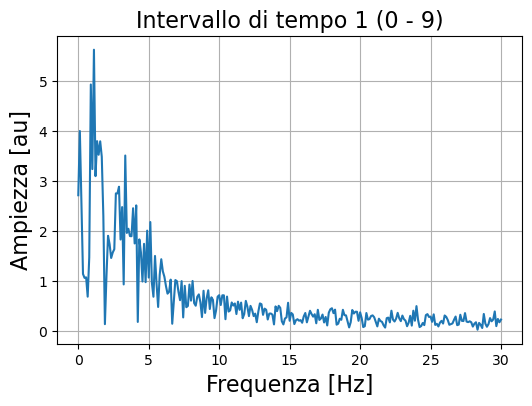

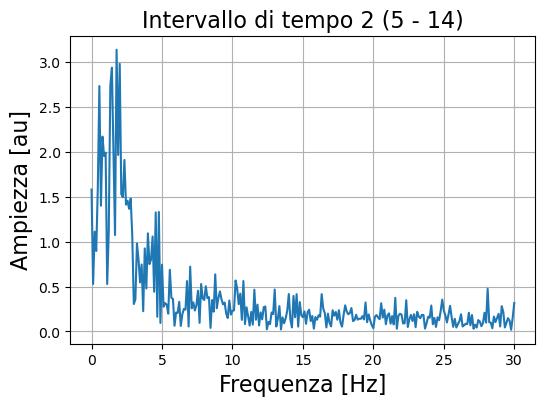

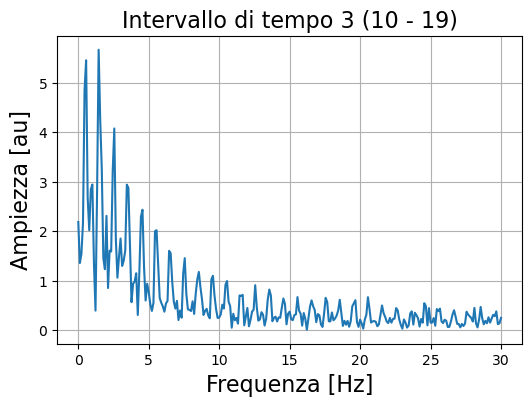

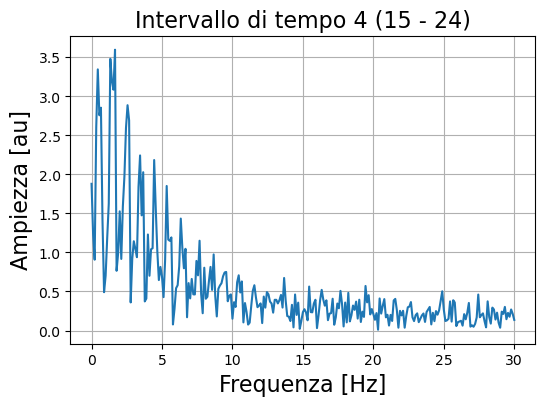

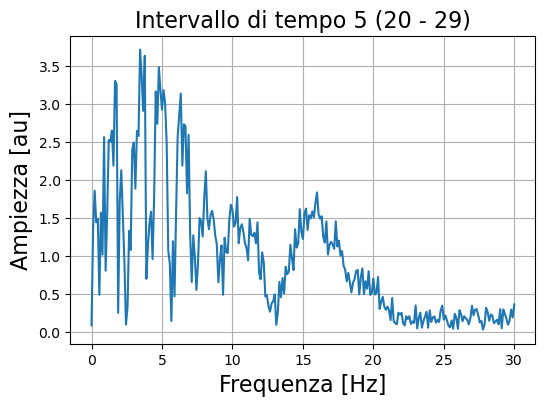

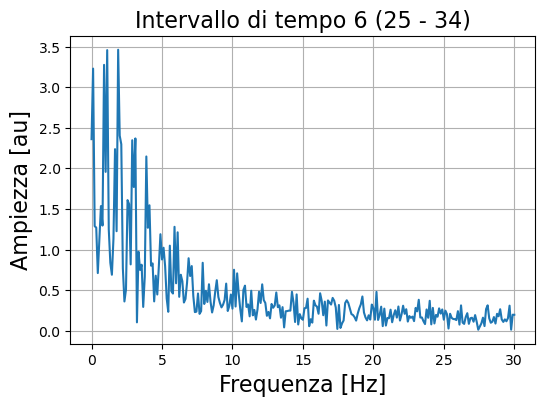

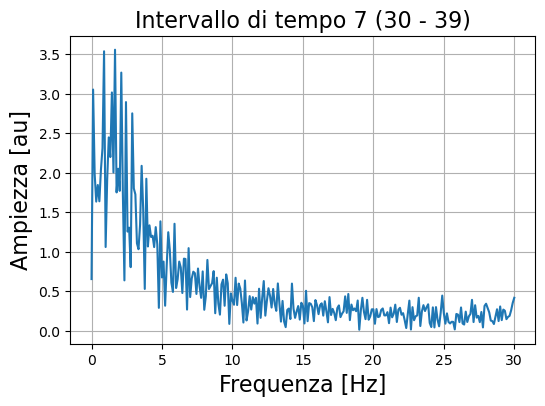

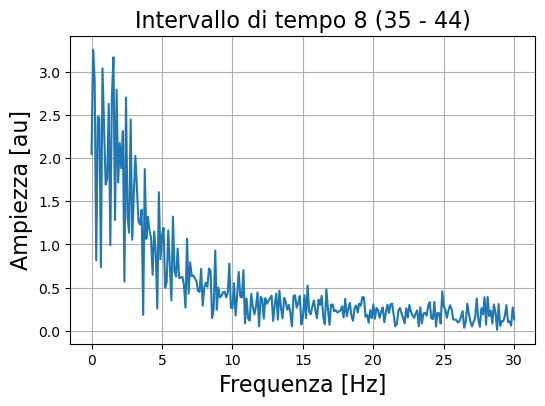

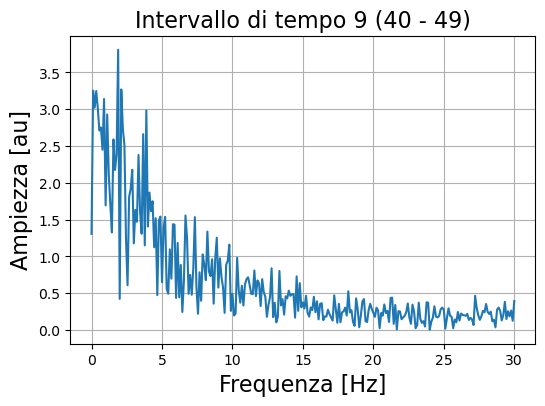

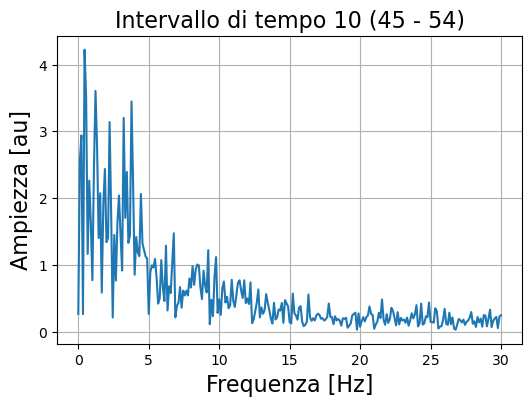

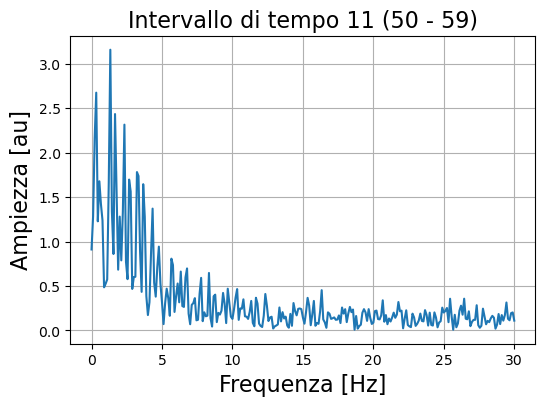

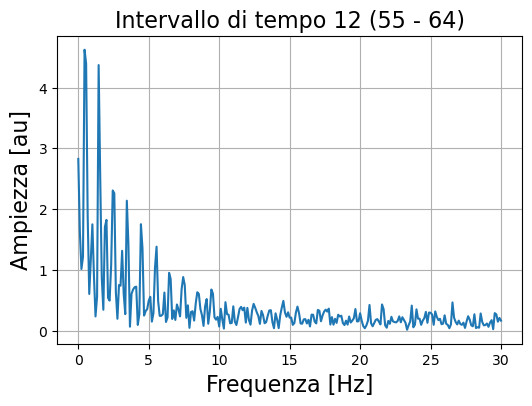

In [2]:
#con overlap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from Lettura_Dati import leggi_file  # funzione per leggere il file
import warnings
import gdown
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from matplotlib.backends.backend_pdf import PdfPages
import os

background = np.load("Background.npy")

# Link con l'ID del file
file_url = "https://drive.google.com/uc?id=15LSYaKYgg9GrVJgwSE_dBTPDefqShAaD"
# Scarica il file da Google Drive
gdown.download(file_url, 'dati.txt', quiet=False)

# Leggi il file
file_path = "dati.txt"
frames = leggi_file(file_path)
frames_array = np.array(frames)
# 
overlap = 4  # n sovrapposizione tra i blocchi
Nm = 9  # n di frame per blocco
T = 1 * Nm 
N = 256 *Nm
bg =Background_PiuFrame(Nm)
background=np.array(bg)
print(background.shape)
# passo di avanzamento tra i blocchi
step = Nm - overlap

block_idx = 0
intervallo_tempo = 1

# ciclo finché c'è spazio per almeno un altro blocco completo
while block_idx + Nm <= len(frames_array):
    # idx inizio e fine del blocco
    start_idx = block_idx
    end_idx = block_idx + Nm

    block_frames = frames_array[start_idx:end_idx]
    block_frames=block_frames.flatten()
    combined_fft = np.fft.fft(block_frames, n=N)

    # tolgo il background
    combined_fft_no_background = combined_fft[:N//2] - background[:N//2]

    xf = fftfreq(N, T/N)[:N//2] 
    xf_selected = xf[(xf >= 0) & (xf <= 30)]
    fft_amplitudes_selected = combined_fft_no_background[(xf >= 0) & (xf <= 30)]

    plt.figure(figsize=(6, 4))
    plt.plot(xf_selected, np.abs(fft_amplitudes_selected))
    plt.title(f'Intervallo di tempo {intervallo_tempo} ({start_idx} - {end_idx})',fontsize=16)
    plt.xlabel('Frequenza [Hz]',fontsize=16)
    plt.ylabel('Ampiezza [au]',fontsize=16)
    plt.grid(True)
    plt.show()

    block_idx += step
    intervallo_tempo += 1
